In [59]:
import glob, os, sys, vcf
import numpy as np
import pandas as pd
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

import statsmodels.api as sm
from statsmodels.tools.tools import pinv_extended  

from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV, Ridge, RidgeCV
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
plt.rcParams["figure.dpi"] = 150
import scipy.stats as st

# Extracting and analyzing data from the VCF files

## Don't need to do any QC filtering because that's for reads from FASTQ files

## These are all post-QC sequences in FASTA files

```bash
bash snp_calling/call_snps.sh sequences/genome/AY988601.1_BGD_CDS.fasta seq_for_analysis/P_whitmer_BGD.fasta alignments P_whitmer_BGD
```

In [2]:
# get all the Bangladesh isolates with clade annotations
P_whitmer = [(seq.id, list(str(seq.seq))) for seq in SeqIO.parse("seq_for_analysis/P_whitmer_BGD.fasta", "fasta")]

names, seqs = list(zip(*P_whitmer))
seq_df = pd.DataFrame({"Pos": np.arange(2130)+1})
seq_df = pd.concat([seq_df, pd.DataFrame(seqs).T], axis=1)

seq_df.columns = ["Pos"] + list(names)

In [3]:
def get_aln_snps(fName):
    '''
    This function gets all the SNPs present in an alignment. 
    '''
    
    if "G_" in fName:
        chrom = "gene=G"
        protein = "G"
    elif "P_" in fName:
        chrom = "gene=P"
        protein = "P"
    
    pos = []
    ref = []
    alt = []    
    
    vcf_reader = vcf.Reader(open(fName, 'r'))

    for record in vcf_reader:
        
        # check that all variants are coming from the correct gene. Might be overkill, but just another sanity check
        if chrom not in record.CHROM or record.CHROM != chrom:
            raise ValueError(f"SNP found outside of {chrom}")
            
        # convert form VCF objects to strings to do string comparison
        alt_alleles = [str(char) for char in record.ALT]

        if "<*>" in alt_alleles:
            alt_alleles.remove("<*>")
        alt_alleles = "".join(alt_alleles)
            
        pos.append(record.POS)
        ref.append(record.REF)
        alt.append(alt_alleles)
        
    return pd.DataFrame({"pos": pos, "ref": ref, "alt": alt})

In [4]:
def get_seq_df(fasta_file, isolates_lst):
    
    seqs = [(seq.id, str(seq.seq)) for seq in SeqIO.parse(fasta_file, "fasta") if seq.id in isolates_lst]
    seq_df = pd.DataFrame(seqs).rename(columns={0:"ID", 1:"Seq"})
    
    data_transf = seq_df.Seq.str.split("", expand=True).iloc[:, 1:-1].T.reset_index()
    data_transf.columns = ["Pos"] + list(seq_df.ID.values)
    
    return data_transf

In [5]:
def create_snp_matrix(fasta_file, isolates_lst, vcf_file):
    
    seq_df = get_seq_df(fasta_file, isolates_lst)
    vcf_df = get_aln_snps(vcf_file)
    
    # search for only sites that have been flagged as having SNPs using the variant caller (using bcftools, done earlier)
    variants_seq_df = seq_df.loc[seq_df.Pos.isin(vcf_df.pos.values)]
    
    # iterate through the positions in the above dataframe
    for pos in variants_seq_df.Pos.values:
    
        # iterate through every isolate (columns)
        for col in variants_seq_df.columns[1:]:

            if variants_seq_df.loc[variants_seq_df.Pos == pos, col].values[0] == vcf_df.loc[vcf_df.pos == pos, "ref"].values[0]:
                variants_seq_df.loc[variants_seq_df.Pos == pos, col] = 0
            else:
                variants_seq_df.loc[variants_seq_df.Pos == pos, col] = 1
              
    # separate the sites
    sites = variants_seq_df.Pos.values
    del variants_seq_df["Pos"]
    
    variants_seq_df = variants_seq_df.T
    variants_seq_df.columns = sites
                
    return sites, variants_seq_df

In [6]:
metadata = pd.read_csv("metadata_all.csv")

isolates_for_model = metadata.query("G == 1 & P == 1 & Country in ['India', 'Bangladesh', 'Malaysia']").ID.values
len(isolates_for_model)

P_snp_sites, P_snp_matrix = create_snp_matrix("sequences/PG/P_seqs.fasta", isolates_for_model, "alignments/P_for_linReg_SNPs.vcf")
G_snp_sites, G_snp_matrix = create_snp_matrix("sequences/PG/G_seqs.fasta", isolates_for_model, "alignments/G_for_linReg_SNPs.vcf")

P_snp_matrix.columns = ["P" + str(col) for col in P_snp_matrix.columns]
G_snp_matrix.columns = ["G" + str(col) for col in G_snp_matrix.columns]

input_mat = pd.concat([P_snp_matrix, G_snp_matrix], axis=1)
input_mat = input_mat.astype(int)
snp_cols = input_mat.columns
isolates = input_mat.index

In [7]:
# check that it's in the same order
assert sum(metadata.query("ID in @isolates_for_model").ID.values != isolates_for_model) == 0

X_india_bgd = input_mat.loc[input_mat.index.isin(metadata.query("Country in ['Bangladesh', 'India']").ID.values)]

y_MB = metadata.query("ID in @isolates_for_model").Country.map({"Malaysia": 0, "India": 1, "Bangladesh": 1}).values
y_india_bgd = metadata.query("ID in @isolates_for_model").Country.map({"India": 0, "Bangladesh": 1}).dropna().values.astype(int)

#pd.DataFrame(y).rename(columns={0:"Y", 1:"I", 2:"B"}).to_csv("plsda_output.csv", index=False)

# recode with dummy variables (analogous to one-hot encoding)
#y = pd.get_dummies(y).values

In [8]:
X_india_bgd.shape, len(y_india_bgd)

((59, 183), 59)

In [9]:
input_mat.values.shape, len(y_MB)

((77, 183), 77)

# Next, encode every sequence in `P_whitmer` as a binary variable representing reference (0) or alternative (1) allele

# PCA of P and G sequences to look for clade clustering

## 1. PCA for all data to check separation by country 

In [8]:
def create_seq_df(metadata):

    # read in all fasta files

    P_all = pd.DataFrame([(seq.id, str(seq.seq)) for seq in SeqIO.parse("sequences/PG/P_seqs.fasta", "fasta")]).rename(columns={0: "ID", 1:"P_seq"})
    G_all = pd.DataFrame([(seq.id, str(seq.seq)) for seq in SeqIO.parse("sequences/PG/G_seqs.fasta", "fasta")]).rename(columns={0: "ID", 1:"G_seq"})

    P_unique = [seq.id for seq in SeqIO.parse("seq_for_analysis/P_deduplicated.fasta", "fasta")]
    G_unique = [seq.id for seq in SeqIO.parse("seq_for_analysis/G_deduplicated.fasta", "fasta")]
    
    seq_df = pd.merge(P_all, G_all, how="outer")
    
    # add variables for whether a sequence is part of the deduplicated sets (deduplication done randomly because metadata not significantly different to justify selecting a particular sequence)
    seq_df["P_dedup"] = seq_df["ID"].isin(P_unique).astype(int)
    seq_df["G_dedup"] = seq_df["ID"].isin(G_unique).astype(int)
    
    return seq_df.merge(metadata, on="ID", how="outer")

In [9]:
# Mapping to use for one-hot encoding. No nucleotide = missing because already checked that there are no indels in these seque
BASE_TO_COLUMN = {'A': 0, 'C': 1, 'T': 2, 'G': 3, 'N': 4}
COLUMN_TO_BASE = {0: "A", 1: "C", 2: "T", 3: "G"}

# Get one hot vector
def get_one_hot(sequence):

    if not pd.isnull(sequence):
        seq_in_index = np.array([BASE_TO_COLUMN.get(b, b) for b in sequence])

        one_hot = np.zeros((len(sequence), 4))

        # only get the non gap sites because otherwise we get indexing errors
        ind_non_gap = np.where(seq_in_index != 4)[0]

        # Assign the found positions to 1
        one_hot[ind_non_gap, seq_in_index[ind_non_gap]] = 1

        return one_hot
    else:
        return np.nan

In [10]:
def pca_elbow(mat, n, scale=False):
     
    if scale:
        scaler = StandardScaler()
        mat = scaler.fit_transform(mat)
    
    pca = PCA(n)
    pca.fit(mat)
    
    plt.plot(np.arange(n)+1, pca.explained_variance_ratio_)
    plt.xticks(np.arange(n)+1)
    
    plt.xlabel("PC")
    plt.ylabel("Proportion of Variance Explained")
    sns.despine()
    plt.show()

In [11]:
# no need to use PCs of the GRM because we ARE looking for differences from population structure
# pca_elbow(np.cov(input_mat.values), 10)

In [12]:
def plot_PCA(snp_matrix, color_col, n_comp=2):
    '''
    Perform PCA using the SNP matrix
    '''
    
    ncbi_ids = snp_matrix.index.values
    
    scaler = StandardScaler()
    X = scaler.fit_transform(snp_matrix.values)
    
    pca_10 = PCA(n_components=10)
    pca_10.fit(X)

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].plot(np.arange(1, 11), pca_10.explained_variance_ratio_)
    
    pca = PCA(n_components=n_comp)
    X_new = pca.fit_transform(X)
    pca_df = pd.DataFrame(X_new).rename(columns=dict(zip(np.arange(n_comp), [f"PC{num}" for num in np.arange(n_comp)+1])))
    pca_df["ID"] = ncbi_ids
    
    sliced_metadata = metadata.loc[metadata.ID.isin(snp_matrix.index)]
    pca_df = pca_df.merge(sliced_metadata[["ID", "Country", "Clade"]], on="ID")
        
    sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue=color_col, alpha=0.7, s=50, ax=ax[1])
    sns.despine()
    plt.show()
    
    return X, pca_df

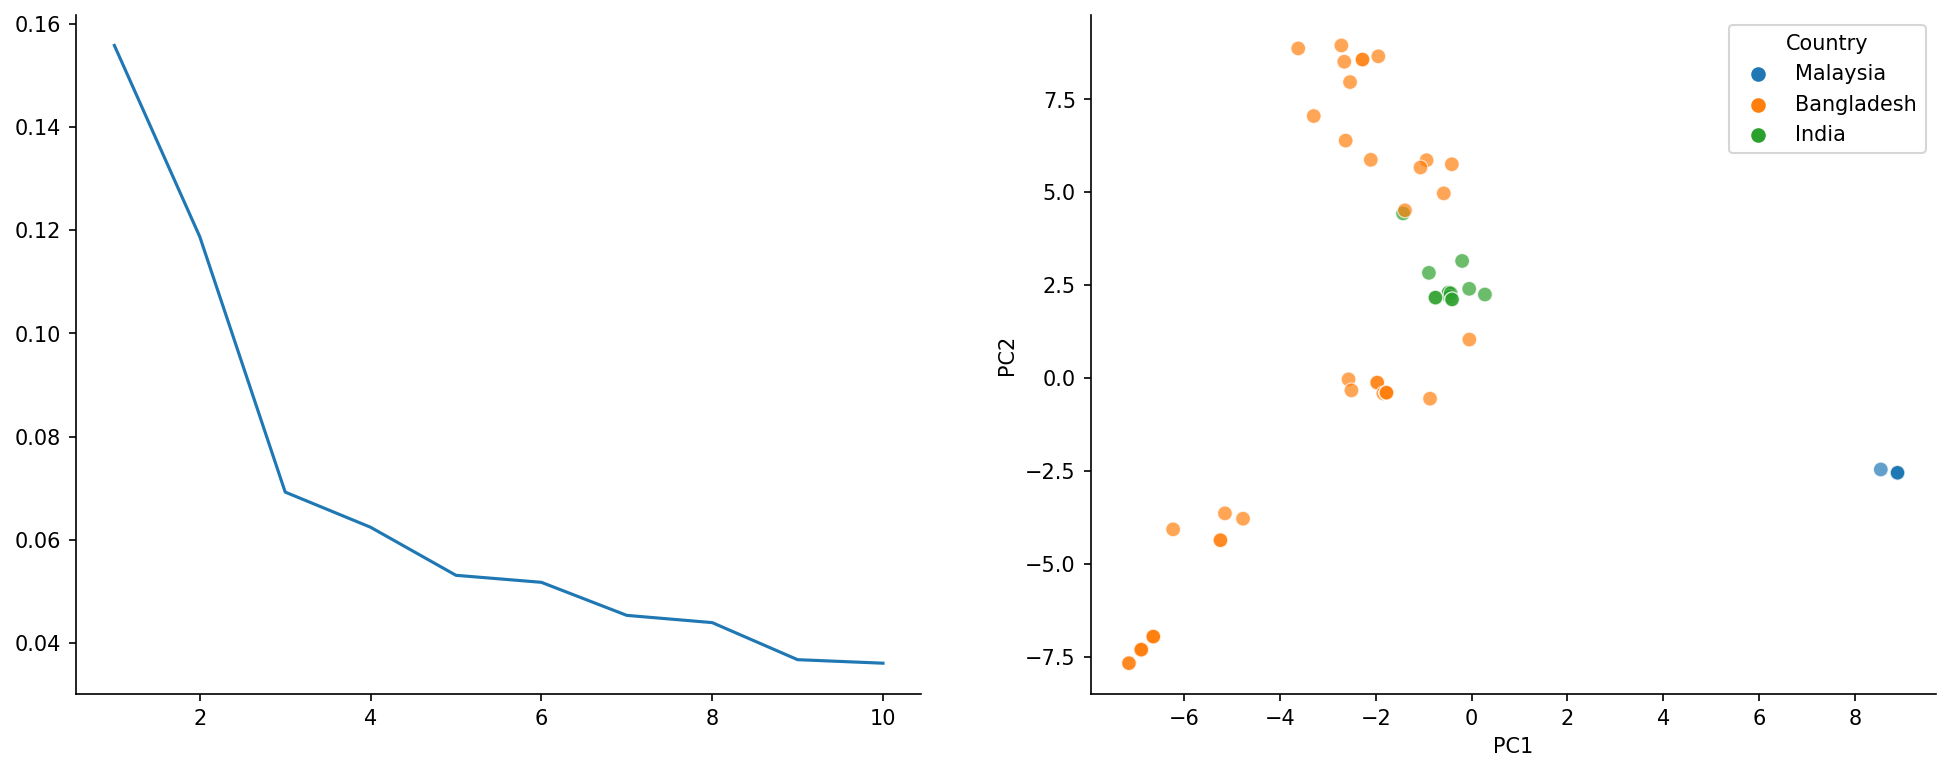

In [13]:
_, pca_df = plot_PCA(input_mat, "Country")

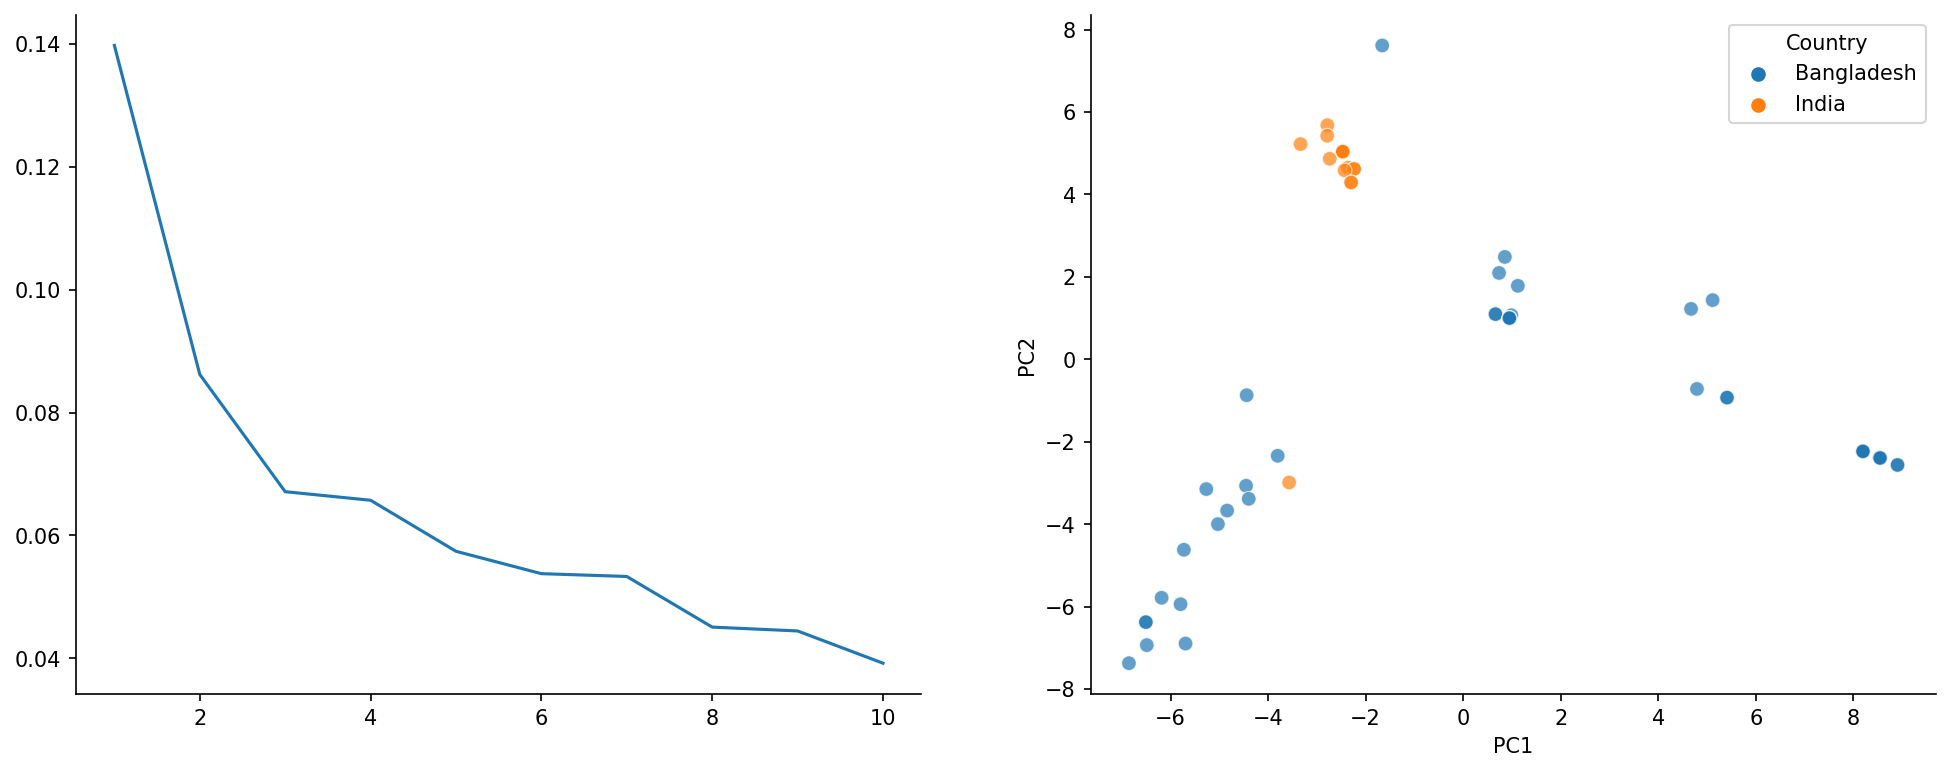

In [14]:
_, pca_df = plot_PCA(input_mat.loc[input_mat.index.isin(metadata.query("Country == 'Bangladesh' | Country == 'India'").ID)],
                     "Country", 2)

# L1/L2-Penalized Logistic Regression, Bangladesh vs. India

## Use `statsmodels` to get p-values

In [39]:
def run_logistic_elasticNet(input_mat, y, scale=True):
    
    if scale:
        scaler = StandardScaler()
        X = scaler.fit_transform(input_mat.values)
    else:
        X = input_mat.values
        
    logistic_cv = LogisticRegressionCV(Cs=np.logspace(-4, 4, 9), 
                                       fit_intercept=True, 
                                       cv=5, 
                                       penalty='elasticnet', 
                                       #scoring='multilabel_confusion_matrix', 
                                       #scoring='precision_recall_fscore_support',
                                       #scoring='log_loss', # cross entropy function for crossentropy
                                       scoring='f1_weighted',
                                       solver='saga', 
                                       max_iter=10000, 
                                       class_weight='balanced', 
                                       l1_ratios=np.linspace(0, 1, 11)
                                      )
    
    logistic_cv.fit(X, y)
    l1_ratio = logistic_cv.l1_ratio_[0]
    alpha = 1/logistic_cv.C_[0]
    print(f"L1 ratio: {l1_ratio}, alpha = {alpha}")
    
    log_reg = LogisticRegression(penalty='elasticnet', 
                                 l1_ratio=logistic_cv.l1_ratio_[0],
                                 C=logistic_cv.C_[0],
                                 fit_intercept=True,
                                 solver='saga',
                                 max_iter=10000,
                                 )
    log_reg.fit(X, y)
    print(f"Score: {round(log_reg.score(X, y), 4)}")
    
    logistic_feat_df = pd.DataFrame(log_reg.coef_).T.rename(columns={0: "coef"})
    logistic_feat_df["feat"] = input_mat.columns
    
    return logistic_feat_df.query("coef != 0")

In [40]:
# India = 0, Bangladesh = 1
india_bgd_df = run_logistic_elasticNet(X_india_bgd, y_india_bgd)

L1 ratio: 0.1, alpha = 100.0
Score: 0.9831


In [63]:
# # get only the features selected by LASSO, then put them into another logistic regression model
# feat_select_india_bgd = X_india_bgd[india_bgd_df["feat"]]

# log_reg_india_bgd = run_logit(feat_select_india_bgd, y_india_bgd)

In [62]:
india_bgd_df

,coef,feat
18,-0.022300,P732
22,-0.077196,P813
44,-0.011142,P942
55,-0.076294,P1099
57,0.084178,P1125
63,-0.076972,P1162
80,-0.076971,P1758
91,-0.076294,P1929
111,-0.060662,G51
164,-0.005712,G1368


# Hierarchical model for Malaysia vs. Bangladesh strains

Because B strain contains isolates from both India and Bangladesh. So include 3 distinct classes, but 2 are part of a larger class.

# Partial Least Squares Discriminant Analysis

In [17]:
n_comp = 2
plsda = PLSRegression(n_comp, scale=True)
plsda.fit(input_mat.values, y)
X_plsda, y_plsda = plsda.transform(input_mat.values, y)

plsda_df = pd.DataFrame(X_plsda).rename(columns=dict(zip(np.arange(n_comp), [f"LV{num}" for num in np.arange(n_comp)+1])))
plsda_df["ID"] = isolates
plsda_df = plsda_df.merge(metadata, on="ID")

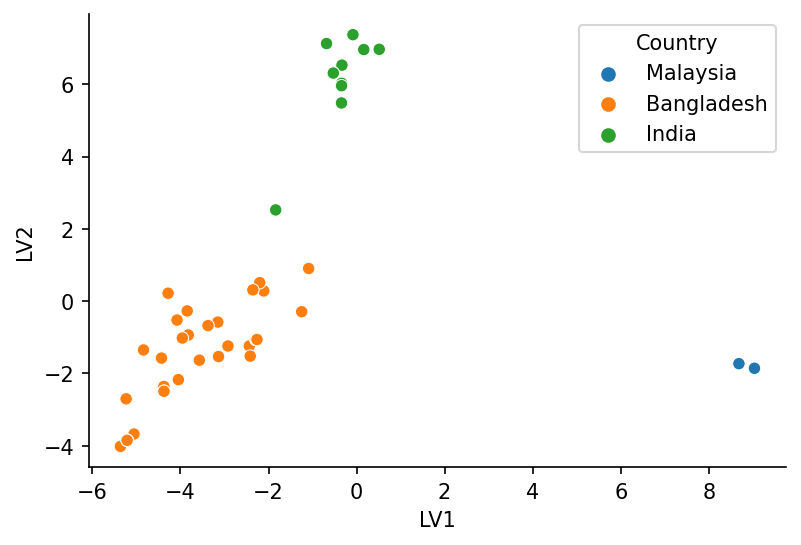

In [18]:
sns.scatterplot(data=plsda_df, x="LV1", y="LV2", hue="Country")
sns.despine()
plt.show()

In [19]:
loadings_df = pd.DataFrame(plsda.x_loadings_).rename(columns={0:"LV1", 1:"LV2"})
#loadings_df.index = snp_cols
loadings_df["feat"] = snp_cols

In [20]:
plsda.coef_.shape

(183, 3)

In [36]:
feat_df = pd.DataFrame(plsda.x_loadings_).rename(columns={0:"LV1", 1:"LV2"})
feat_df["feat"] = snp_cols

In [37]:
feat_df

,LV1,LV2,feat
0,-0.027210,-0.018900,P99
1,-0.018556,-0.013852,P167
2,-0.018556,-0.013852,P175
3,-0.091878,-0.139261,P181
4,-0.061847,-0.030826,P190
...,...,...,...
178,-0.048605,0.206783,G1656
179,0.167051,-0.084191,G1659
180,-0.004512,0.008302,G1706
181,-0.020066,-0.012438,G1746


In [91]:
all_pos = []

for record in vcf.Reader(filename="alignments/P_for_linReg_SNPs.vcf"):    
    all_pos.append(record.POS)
    
bgd_pos = []

for record in vcf.Reader(filename="alignments/P_whitmer_BGD_SNPs.vcf"):    
    bgd_pos.append(record.POS)

In [95]:
# suggests that all positions from aligning only BGD sequences are also found when aligning everything
set(bgd_pos) - set(all_pos)

set()

In [96]:
set(all_pos) - set(bgd_pos)

{218,
 241,
 321,
 639,
 744,
 826,
 837,
 848,
 870,
 899,
 909,
 928,
 935,
 948,
 1072,
 1098,
 1129,
 1632,
 2026}

set()